# Lightweight Fine-Tuning Project

TODO: In this cell, describe your choices for each of the following

* PEFT technique: LoRA
* Model: gpt2
* Evaluation approach:
* Fine-tuning dataset: Amazon reviews

## Loading and Evaluating a Foundation Model

TODO: In the cells below, load your chosen pre-trained Hugging Face model and evaluate its performance prior to fine-tuning. This step includes loading an appropriate tokenizer and dataset.

In [28]:
!pip install numpy pandas torch scikit_learn transformers datasets peft

In [45]:
# import packages
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments, GPT2Tokenizer, GPT2ForSequenceClassification
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, AutoPeftModelForSequenceClassification


In [46]:
# load pre trained model and tokenizer, set pad token
# https://huggingface.co/openai-community/gpt2
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2ForSequenceClassification.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
# load and preprocess the dataset
# https://huggingface.co/datasets/fancyzhx/amazon_polarity
dataset = load_dataset("amazon_polarity")
# print(dataset['train'][0])
# print(dataset['test'][0])

# Select a smaller portion of the dataset for quick processing
small_train_dataset = dataset['train'].select(range(50000))
small_test_dataset = dataset['test'].select(range(40000))


In [48]:
def preprocess_function(examples):
    return tokenizer(examples['content'], padding='max_length', truncation=True)

# FULL NORMAL DATASET
# tokenized_train_dataset = dataset['train'].map(preprocess_function, batched=True)
# tokenized_test_dataset = dataset['test'].map(preprocess_function, batched=True)

# preprocessing function for smaller datasets so I don't have to wait so long
tokenized_train_dataset = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = small_test_dataset.map(preprocess_function, batched=True)

# convert the format of the dataset
def convert_to_torch_format(dataset):
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

convert_to_torch_format(tokenized_train_dataset)
convert_to_torch_format(tokenized_test_dataset)


In [43]:
# Split the dataset into training and test sets
train_dataset = tokenized_train_dataset
test_dataset = tokenized_test_dataset

# Smaller datasets for testing
two_small_train_dataset = train_dataset.select(range(300))
two_small_test_dataset = test_dataset.select(range(200))

In [54]:
# Define compute_metrics function
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return {"accuracy": accuracy_score(eval_pred.label_ids, predictions), "precision": precision_score(eval_pred.label_ids, predictions)}


# Training arguments
gpt2_training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    logging_dir='./logs',
    logging_steps=10,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    # num_train_epochs = 2,
    num_train_epochs = 5,
    weight_decay=0.01,
    save_strategy="epoch",
)

# Initialize Trainer with the base model
trainer = Trainer(
    model=model,
    args=gpt2_training_args,
    # train_dataset=train_dataset, # full dataset takes much longer to train
    # eval_dataset=test_dataset,
    train_dataset= two_small_train_dataset, # added for testing, smaller datasets
    eval_dataset= two_small_test_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# Train the model and evaluate
trainer.train()
original_model_eval_results = trainer.evaluate()
print(f"Original model evaluation results: {original_model_eval_results}")


Epoch,Training Loss,Validation Loss,Accuracy,Precision
1,0.202300,0.586584,0.850000,0.883495
2,0.576600,0.659726,0.845000,0.875000
3,0.057100,0.687276,0.850000,0.876190
4,0.115800,0.690540,0.850000,0.876190
5,0.283900,0.691338,0.840000,0.873786


Original model evaluation results: {'eval_loss': 0.6913375854492188, 'eval_accuracy': 0.84, 'eval_precision': 0.8737864077669902, 'eval_runtime': 15.132, 'eval_samples_per_second': 13.217, 'eval_steps_per_second': 2.247, 'epoch': 5.0}


## Performing Parameter-Efficient Fine-Tuning

TODO: In the cells below, create a PEFT model from your loaded model, run a training loop, and save the PEFT model weights.

In [51]:
# LoRA configuration
peft_config = LoraConfig(
    r=16,  # rank of the low-rank decomposition
    task_type="SEQ_CLS",  # task type
    lora_alpha=32,
    lora_dropout=0.2,  # dropout rate
    target_modules=['attn.c_attn', 'attn.c_proj'],
    bias="none",
)

# init the base model
lora_model = get_peft_model(model, peft_config)

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1091: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [53]:
# Training arguments for LoRA model
lora_training_args = TrainingArguments(
    output_dir='./results/lora_results',
    eval_strategy="epoch",
    logging_dir='./lora_logs',
    logging_steps = 10,
    per_device_train_batch_size = 6,
    per_device_eval_batch_size = 6,
    # num_train_epochs = 2,
    num_train_epochs = 5,
    weight_decay = 0.01,
    save_strategy = "epoch",
)

# init trainer for LoRA model
lora_trainer = Trainer(
    model=lora_model,
    args=lora_training_args,
    # train_dataset=tokenized_train_dataset, # full dataset takes longer to train
    # eval_dataset=tokenized_test_dataset,
    train_dataset=two_small_train_dataset,
    eval_dataset=two_small_test_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# Train the LoRA model and evaluate the model
lora_trainer.train()
lora_model_eval_results = lora_trainer.evaluate()
print(f"LoRA model evaluation results: {lora_model_eval_results}")

Epoch,Training Loss,Validation Loss,Accuracy,Precision
1,0.203500,0.459311,0.860000,0.917526
2,0.610800,0.513158,0.860000,0.900990
3,0.145300,0.559212,0.850000,0.883495
4,0.116700,0.570648,0.850000,0.883495
5,0.274200,0.577343,0.850000,0.883495


LoRA model evaluation results: {'eval_loss': 0.577342689037323, 'eval_accuracy': 0.85, 'eval_precision': 0.883495145631068, 'eval_runtime': 15.1485, 'eval_samples_per_second': 13.203, 'eval_steps_per_second': 2.244, 'epoch': 5.0}


In [55]:
# Save the PEFT LoRA model
lora_trainer.save_model("./models/Lora")

## Performing Inference with a PEFT Model

TODO: In the cells below, load the saved PEFT model weights and evaluate the performance of the trained PEFT model. Be sure to compare the results to the results from prior to fine-tuning.

In [56]:
print("Compare the two models \n ----------------------")
print(f"LoRA model evaluation results: {lora_model_eval_results}\n")
print(f"Original model evaluation results: {original_model_eval_results}")

Compare the two models 
 ----------------------
LoRA model evaluation results: {'eval_loss': 0.577342689037323, 'eval_accuracy': 0.85, 'eval_precision': 0.883495145631068, 'eval_runtime': 15.1485, 'eval_samples_per_second': 13.203, 'eval_steps_per_second': 2.244, 'epoch': 5.0}

Original model evaluation results: {'eval_loss': 0.6913375854492188, 'eval_accuracy': 0.84, 'eval_precision': 0.8737864077669902, 'eval_runtime': 15.132, 'eval_samples_per_second': 13.217, 'eval_steps_per_second': 2.247, 'epoch': 5.0}


In [57]:
# Load the saved PEFT model
loaded_lora_model = AutoPeftModelForSequenceClassification.from_pretrained("./models/Lora", num_labels=2)
loaded_lora_model.config.pad_token_id = loaded_lora_model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
# Training arguments for LoRA model
loaded_lora_training_args = TrainingArguments(
    output_dir='./results/lora_results',
    eval_strategy = "epoch",
    logging_dir='./lora_logs',
    logging_steps=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
)

# init trainer for LoRA model
loaded_lora_trainer = Trainer(
    model=loaded_lora_model,
    args=loaded_lora_training_args,
    train_dataset=tokenized_train_dataset, # full dataset takes longer to train
    eval_dataset=tokenized_test_dataset,
    # train_dataset=two_small_train_dataset,
    # eval_dataset=two_small_test_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# loaded_lora_trainer.train()

In [59]:
# Evaluate the PEFT model
loaded_lora_model_eval_results = loaded_lora_trainer.evaluate()

# Compare models
print("Compare the models \n -------------------")
print(f"Original model evaluation results: {original_model_eval_results}\n")
print(f"LoRA model evaluation results: {lora_model_eval_results}\n")
print(f"Loaded LoRA Model Evaluation: {loaded_lora_model_eval_results}")



Compare the models 
 -------------------
Original model evaluation results: {'eval_loss': 0.6913375854492188, 'eval_accuracy': 0.84, 'eval_precision': 0.8737864077669902, 'eval_runtime': 15.132, 'eval_samples_per_second': 13.217, 'eval_steps_per_second': 2.247, 'epoch': 5.0}

LoRA model evaluation results: {'eval_loss': 0.577342689037323, 'eval_accuracy': 0.85, 'eval_precision': 0.883495145631068, 'eval_runtime': 15.1485, 'eval_samples_per_second': 13.203, 'eval_steps_per_second': 2.244, 'epoch': 5.0}

Loaded LoRA Model Evaluation: {'eval_loss': 2.307964563369751, 'eval_accuracy': 0.4915, 'eval_precision': 0.6067415730337079, 'eval_runtime': 2989.4783, 'eval_samples_per_second': 13.38, 'eval_steps_per_second': 1.673}


# Results

After evaluating the models. It's clear that the PEFT model has a better accuracy then then the pretrained HF gpt2 model. There wasn't an Immense difference between the models in relation to their accuracies and precision. Most tests were done using small test sections of the dataset. Both images below are from the small test dataset. If the model was trained on the full dataset the results could improve. Regardless, Low Rank Adaptation (LoRA) showed to be a successful fine-tuning method for this project.


-----------




gpt2 model

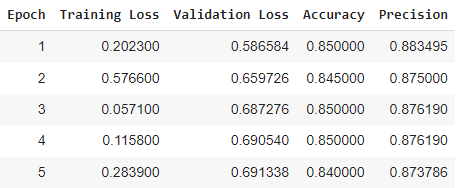



PEFT model LoRA



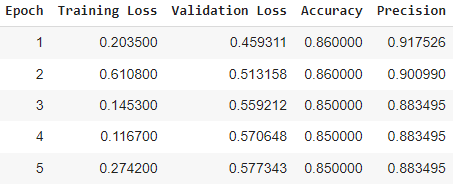